# Eigengene SVA Analysis

**Created**: 13 December 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(data.table)
library(parallel)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
geno <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")
colnames(geno) <- c("chr", "snp", "cM", "pos", "minor", "major")

## Manhattan Plots

The genome-wide significance threshold is calculated using a Bonferroni correction of a significance threshold of 0.05. We performed tests for 66 individual eigengenes for 70300 SNPs. This threshold is slightly larger than 1e-8, so I will use that cutoff instead.

Under the null distribution, $t=\frac{\hat{\beta}}{SE}$ follows a T distribution with degrees of freedom close to $n$. The genomic inflation score measures the deviation from this expected distribution while accounting for outliers expected from a few true positives. The score is

$$\lambda = \frac{\text{median}(t^2)}{\text{median}(\chi_1^2)}$$

where $t$ is the T-statistic for $\beta$. Here, we assume that the T Distribution can be approximated as a standard normal distribution since $n$ is relatively large.

In [4]:
me.assocs <- do.call(rbind, lapply(list.files("~/gains_team282/nikhil/expression/eigengene_sva/initial_pass/", pattern="*.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
}))

In [5]:
lambdas <- me.assocs %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(lambda = median(qchisq(1 - p, 1)) / qchisq(0.5, 1))

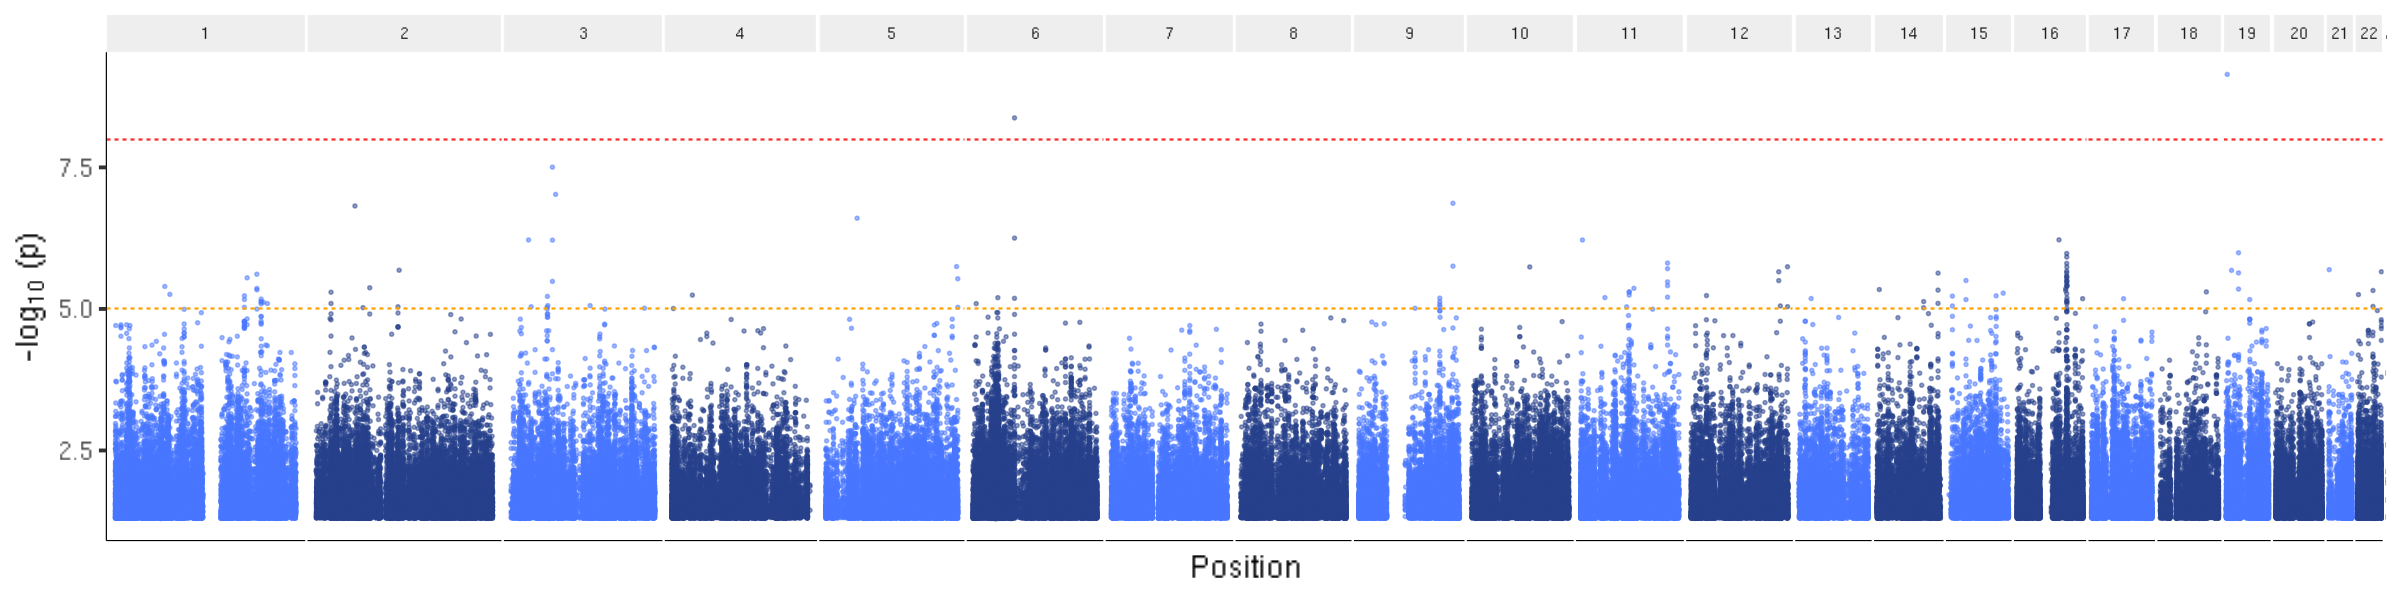

In [6]:
options(repr.plot.width=20, repr.plot.height=5)

plot.data <- me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "Even", "Odd")) %>%
    dplyr::mutate(Log.10.p = -log10(p))

plot.data %>%
    ggplot() +
    geom_point(aes(x=pos, y=Log.10.p, color=chr.type), size=I(0.5), alpha=0.5) +
    geom_hline(yintercept=-log10(1e-5), lty=2, color="orange") +
    geom_hline(yintercept=-log10(1e-8), lty=2, color="firebrick1") +
    scale_color_manual(values=c("Even" = "royalblue4", "Odd" = "royalblue1")) +
    facet_grid(~chr, scale="free_x", space="free_x") +
    guides(color="none") +
    xlab("Position") + ylab(expression('-log'[10]~'(p)')) +
    ggplot_theme +
    theme(
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.spacing=unit(0.1, "lines"),
        strip.text=element_text(size=9)
    )

ggsave("04_Expression/results/manhattan_initial_pass.png", width=20, height=5, dpi=600)

## P-Value Q-Q Plots

Under the null hypothesis, we expect p-values for multiple tests to have a uniform distribution. If there is inflation in the data (that is, variants are associated with the quantitative variable due to population stratification), this p-value distribution will be skewed towards significance. This is quantified with the genomic inflation factor ($\lambda$). We can also plot the Q-Q plot for the p-values to check for deviation from the expected distribution. The p-values for true significant hits (close to 0) should deviate from the distribution, but the rest (indicating true negatives) should follow the distribution faithfully.

In [7]:
me.assocs <- lapply(c("ME_1.tsv", "ME_59.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
})

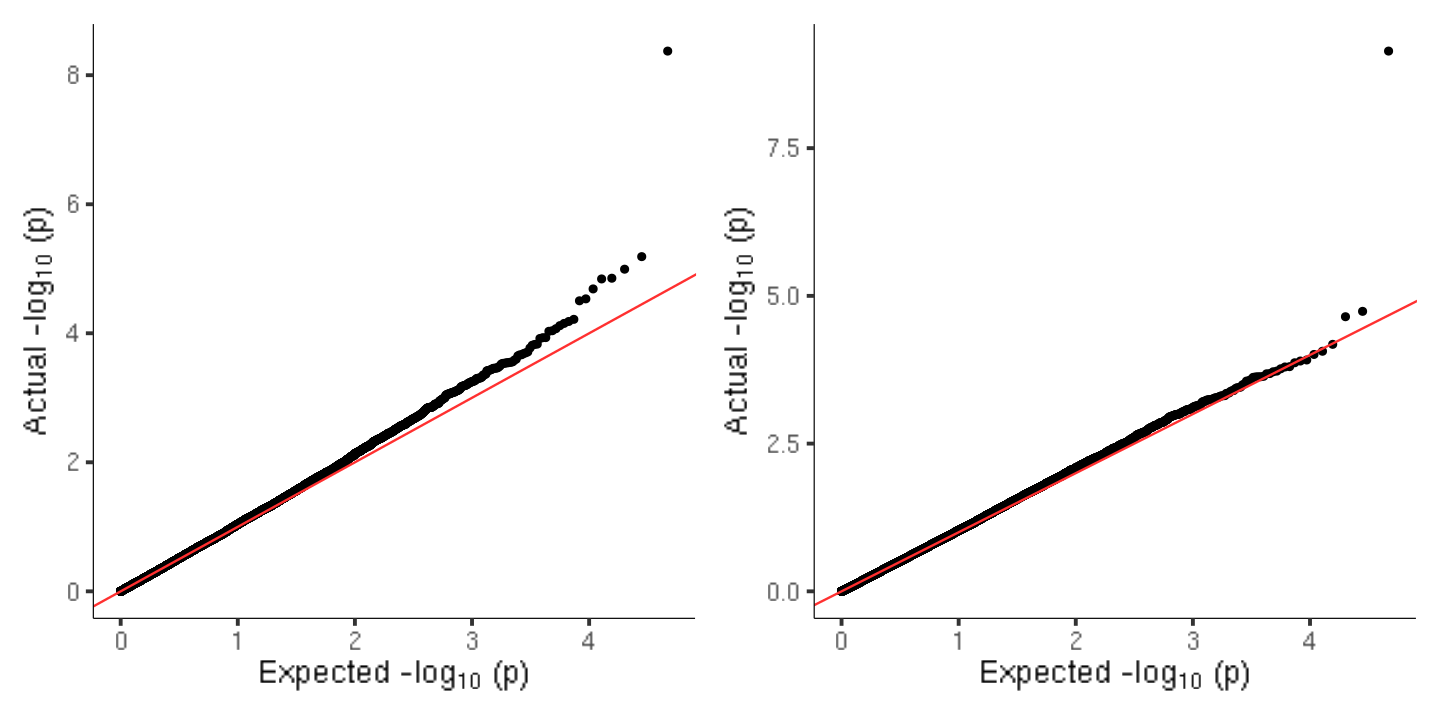

In [8]:
options(repr.plot.width=12, repr.plot.height=6)

exp.p.assocs <- lapply(me.assocs, function(me.assoc) {
    me.assoc %>%
        as.data.frame() %>%
        dplyr::mutate(expected.p=(rank(p, ties.method="first") + 0.5) / (length(p) + 1)) %>%
        dplyr::mutate(Log.10.P=-log10(p)) %>%
        dplyr::mutate(Expected.Log.10.P=-log10(expected.p))
})

plots <- lapply(exp.p.assocs, function(exp.p.assoc) {
    dplyr::bind_rows(
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P < 5) %>% dplyr::sample_frac(0.001),
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P >= 5)
    ) %>%
        ggplot() +
        geom_point(aes(x=Expected.Log.10.P, y=Log.10.P)) +
        geom_abline(slope=1, intercept=0, color="firebrick1") +
        xlab(expression("Expected -log"[10]~"(p)")) +
        ylab(expression("Actual -log"[10]~"(p)")) +
        ggplot_theme
})

plots[[1]] + plots[[2]]

## Module Information

In [31]:
mod.info <- read.csv("~/gains_team282/nikhil/expression/gene_expression_annotations/xCell_Signatures.csv", row.names=1)

In [34]:
mod.info %>%
    dplyr::filter(Module == "Module_1" | Module == "Module_59")

Module,Cell.Type,Mean.Odds.Ratio,Median.Odds.Ratio,Odds.Ratio.Min,Odds.Ratio.Max,xCell.Genes,Module.Overlap.Genes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Module_1,Macrophages,3.036346,3.036346,3.015842,3.056851,ACADVL|ACP2|ARSB|ATP6V1A|ATP6V0C|ATP6V1C1|CD63|CETN2|CCR1|SLC31A1|COX5B|COX15|CYBB|DBI|ECHS1|FDX1|GRB2|HADHB|HEXA|HEXB|HK3|HMGCL|ITGAX|KIFC3|TNPO1|LAIR1|LAMP1|MGST3|MSR1|NARS|NDUFA8|NDUFB6|NDUFS8|PRDX1|PEX14|MAPK13|PSMD10|PTPN12|PEX19|QDPR|RAB1A|RAB5C|RALA|RENBP|CLIP1|CCL7|CCL18|SDHB|SRC|STX4|TCEB1|MLX|TRAF3|NSMAF|AGPS|MARCO|SNX4|ATP6V1F|LONP1|GSTO1|BAG3|CIR1|FEZ2|PDCD6IP|SNUPN|BCAP31|STAM2|IGSF6|ZMPSTE24|TMEM147|VTI1B|TGOLN2|SPIN1|LILRB4|EMILIN1|VSIG4|EFR3A|FKBP15|CLEC5A|IBTK|NPTN|ATP2C1|SIGLEC9|ADAMDEC1|CNIH4|GLRX2|DERA|NDUFAF1|HSD17B12|ZDHHC3|TNFRSF12A|MS4A4A|ATP6V1D|ATP6V1H|TMBIM4|STYXL1|BTBD1|NUDT9|TMEM33|NOP10|TMEM127|ACTR10|KCMF1|TULP4|C12orf4|RTN4|MKL2|HAMP|DNASE2B|KLHL12|NSUN3|ELOVL1|SLC30A5|MAPKAP1|LONRF3|TCEAL4|CHD9|TM2D1|MFSD7|G6PC3|TBC1D16|SEPT10|ZDHHC24|HCCS|UQCRC2|USF2|CEPT1|TMEM115|TRAPPC3|SLC25A24|C7orf25|PANK3|SETD3,ATP6V0C|ATP6V1C1|CCR1|COX15|HADHB|PSMD10|PEX19|RAB1A|CLIP1|FEZ2|STAM2|TGOLN2|FKBP15|NPTN|SIGLEC9|DERA|TMEM33|RTN4|KLHL12|NSUN3|SLC25A24
Module_1,Macrophages M1,2.858697,2.858697,2.858697,2.858697,ACP2|ADRA2B|ALCAM|ABCD1|ATOX1|ATP6V0C|ATP6V1E1|BLVRA|C1QA|CD48|CD63|CLCN7|TPP1|CLTC|CCR1|CMKLR1|SLC31A1|COX5B|FCER1G|FDX1|FOLR2|FPR3|FTL|HEXB|HK3|IL10|IL12B|ITGAE|LAIR1|CXCL9|MMP19|NARS|NDUFS2|P2RX7|PDCL|MAPK13|PTGIR|PTPRA|RELA|CCL7|CCL8|CCL19|CCL22|SRC|STX4|TCEB1|TFRC|AGPS|MARCO|SNX3|CD84|USP14|ITGB1BP1|ATP6V1F|TRIP4|CD163|CIAO1|WTAP|ARHGEF11|ABI1|SCAMP2|ACTR2|BCAP31|ZMPSTE24|BCKDK|EXOC5|STIP1|UQCR11|SDS|LILRB4|OGFR|TFEC|FKBP15|DNAJC13|TDRD7|STX12|IL17RA|ABTB2|FAM32A|SIGLEC7|SIGLEC9|ADAMDEC1|CECR5|SLC25A24|NRBP1|MS4A4A|TREM2|OTUD4|PQLC2|HAUS2|ARL8B|NECAP2|WDR11|ZC3H15|CCDC47|UTP3|MRS2|HAMP|MRPL40|VPS33A|CORO7|LIMD2|TMX1|DOT1L|ADO|ADCK2,ALCAM|ATP6V0C|CLTC|CCR1|IL10|PTPRA|ABI1|ACTR2|FKBP15|TDRD7|STX12|IL17RA|SIGLEC9|SLC25A24|ARL8B|CCDC47
Module_1,aDC,2.851084,2.851084,2.568235,3.133933,ACHE|ADPRH|ALOX15B|ANXA5|XIAP|ARF3|RHOG|ATP1B3|BLVRA|C1QA|C1QB|C3AR1|CASP5|CD80|CD86|CCR5|CMKLR1|EIF5|ENO1|ETV3|FCER1G|FCER2|FPR3|GMFB|GNG5|GRB2|RAPGEF1|HCK|HLA-DQA1|HRH2|DNAJA1|IL2RA|IL3RA|IL9|IL10|IL10RA|IL12B|IMPDH1|IRF4|KCNMB1|LAIR1|LOR|RAB8A|CXCL9|MTF1|NFE2L2|NFKB1|NFKBIB|NRAS|OSM|P2RX7|PAK2|PGK1|PITPNA|MAP2K1|PTGIR|RAB5A|RELA|CLIP1|S100A10|CCL1|CCL4|CCL7|CCL8|CCL17|CCL18|CCL19|CCL22|CCL23|CCL24|SLAMF1|SLC1A2|SLC6A12|SIGLEC1|SRC|STAT2|TCF21|DYNLT1|TPI1|TRAF1|TNFRSF4|TXN|VRK2|XPNPEP1|ZBTB17|CUL1|RRP1|SCARF1|ALDH1A2|TAX1BP1|SOCS3|SPAG9|TMSB10|MAP3K13|TRIP4|H6PD|WTAP|ARHGEF11|TMCC2|HS3ST3B1|ABI1|BCL2L11|ARPC4|ARFRP1|RAMP3|LILRB2|BCKDK|CXCL13|EXOC5|MTHFD2|SEC24A|NEU3|LILRB1|CD300C|LILRB5|RAB35|OGFR|HPS5|TREX1|TFEC|RAB21|KDM6B|FAM175B|MGRN1|TDRD7|ABCA6|DNPEP|ACOT9|NUP62|BCL2L13|FBXL4|SIGLEC7|CYTH4|SIGLEC9|TOR1B|GPR132|IL19|CD209|ANKFY1|AZIN1|RIN2|TBC1D13|GPN2|C1orf27|ARL8B|ZNF654|TBC1D22B|MFN1|SCYL2|CHFR|KCNK13|C5orf15|RPGRIP1|CAMK1G|DENND1A|GPR107|HAMP|MIIP|NSUN3|MMP25|UBE2Z|TNIP2|OPA3|TMX1|SLCO5A1|NETO2|MED25|SLC25A28|ADPGK|MAGT1|DOT1L|LILRA5|TMEM41B|ELL|N4BP1|ABTB2|TRPC4AP|SNX11|CHMP5|NECAP2,ANXA5|ARF3|GMFB|IL10|MTF1|NFKB1|MAP2K1|CLIP1|VRK2|TAX1BP1|HS3ST3B1|ABI1|SEC24A|TDRD7|FBXL4|SIGLEC9|TOR1B|AZIN1|ARL8B|SCYL2|CHFR|NSUN3|ADPGK|TMEM41B
Module_1,Monocytes,2.709860,2.709860,2.709860,2.709860,AP1G1|ASGR2|BNIP2|TSPO|CASP5|CD1E|TNFRSF8|CD33|CDK9|CSF1R|DDX3X|DHX8|DLG4|GPR183|ETF1|ETV3|EWSR1|FCAR|FCN1|FOLR2|FOLR3|FPR2|GALNT3|HIF1A|HNRNPU|AGFG1|KCNC3|KCNMB1|MEFV|MMP17|MTF1|MTHFR|OSM|PDE6H|CFP|PGGT1B|PLD2|PLEK|POU2F2|PPM1A|PRKACA|MAPK6|MAP2K1|PTGIR|RAB5A|RELA|CLIP1|S100A10|S100A12|SH3BP2|SLC11A1|STX5|SUPT6H|PHLDA2|UBE2D1|UPK3A|PTP4A2|ELL|NDST2|DNAH17|PTCH2|RIOK3|KSR1|BCL10|SOCS3|USP8|DDX21|PLAA|CD101|QKI|WTAP|AATK|TTLL4|BCL2L11|MPHOSPH6|AKAP8|LILRB2|APBB3|CLEC10A|GNA13|MAP3K2|LILRB1|CD300C|FGL2|LILRA1|OGFR|AKAP13|TREX1|CD93|IQSEC2|STAB1|JMJD6|CBX6|CLEC5A|PGLS|GGA1|FBXL5|CLEC4E|SERP1|GNMT|GPR162|VENTX|RABGEF1|TBK1|S

## Conditional Analysis

In [9]:
library(data.table)
library(lme4)
library(parallel)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [10]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")

In [41]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt") %>%
    t() %>% as.data.frame()

In [11]:
lead.cis.eqtl <- read.table("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/eigenMT/ciseqtl_eigenMT_corrected.txt")

In [17]:
mod.1.info <- merge(modules, lead.cis.eqtl, by.x="Gene", by.y="gene") %>%
    dplyr::filter(Module == "Module_1", Sig)

mod.59.info <- merge(modules, lead.cis.eqtl, by.x="Gene", by.y="gene") %>%
    dplyr::filter(Module == "Module_59", Sig)

In [56]:
"ENSG00000079313" %in% mod.59.info$Gene

[1] FALSE

In [42]:
# Design Matrix
design.matrix <- read.csv("/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/eigengene_sva/mapping_data.csv")

# Genotype Matrix
genotypes <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/eigengene_sva_genotypes.raw", sep=" ", drop=2:6)

# Clean Genotype Matrix
patient.sample.match <- match(design.matrix$GAinS.ID, genotypes$FID)
genotypes <- genotypes[patient.sample.match,]
colnames(genotypes) <- gsub("X", "", colnames(genotypes))
colnames(genotypes) <- sapply(strsplit(colnames(genotypes), "_"), function(x) { x[1] })
genotypes[, 1] <- NULL
genotypes <- as.matrix(genotypes)
rownames(genotypes) <- design.matrix$Sample.ID

genotype.ids <- colnames(genotypes)
                              
# Clean gene expression matrix
gene.exp <- gene.exp[design.matrix$Sample.ID, ]

In [44]:
# Create a full design matrix with all genotypes
genotypes <- cbind(design.matrix, genotypes, gene.exp)

all.vars <- colnames(design.matrix)
eigens <- colnames(design.matrix)[grepl("^ME", colnames(design.matrix))]
covs <- setdiff(setdiff(all.vars, eigens), c("Sample.ID", "GAinS.ID"))

In [45]:
ME = "ME_1"
snp = "rs16888392"
mediator = "ENSG00000112210"

# ME = "ME_59"
# snp = "rs75443592"

In [50]:
variant.design <- genotypes[,c(ME, snp, mediator, covs, "GAinS.ID")]

f.null <- as.formula(paste0(ME, "~", mediator, "+", paste0(covs, collapse="+"), "+(1|GAinS.ID)"))
model.null <- lmer(f.null, data=variant.design, REML=FALSE)

f.alt <- as.formula(paste0(ME, "~`", snp , "`+", mediator, "+", paste0(covs, collapse="+"), "+(1|GAinS.ID)"))
model.test <- lmer(f.alt, data=variant.design, REML=FALSE)

if (!all(complete.cases(variant.design[, snp]))) {
    model.null <- update(model.null, subset=complete.cases(variant.design[, snp]))
    model.test <- update(model.test, subset=complete.cases(variant.design[, snp]))
}

# data.frame(matrix(
#     data=c(
#         summary(model.test)$coefficients[snp, ],
#         anova(model.null, model.test)["model.test", "Pr(>Chisq)"]
#     ),
#     nrow=1, ncol=4
# ))

summary(model.test)$coefficients

,Estimate,Std. Error,t value
(Intercept),2.551649e-04,0.0003565039,0.71574216
rs16888392,1.146118e-03,0.0001844454,6.21386117
ENSG00000112210,-9.572986e-04,0.0003927721,-2.43728755
sex,-3.579258e-04,0.0001758516,-2.03538617
PC1,1.072852e-03,0.0026698086,0.40184611
PC2,-2.001244e-03,0.0026539833,-0.75405303
PC3,-5.607889e-04,0.0026764474,-0.20952733
PC4,-6.891884e-04,0.0024246864,-0.28423814
PC5,3.902923e-03,0.0028559455,1.36659566
PC6,-4.249755e-03,0.0028184256,-1.50784715
